In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image
import cv2
import plotly.express as px

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report

2024-05-20 06:15:20.374233: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 06:15:20.374326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 06:15:20.508706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/food41
/kaggle/input/food41/meta
/kaggle/input/food41/meta/meta
/kaggle/input/food41/images
/kaggle/input/food41/images/macarons
/kaggle/input/food41/images/french_toast
/kaggle/input/food41/images/lobster_bisque
/kaggle/input/food41/images/prime_rib
/kaggle/input/food41/images/pork_chop
/kaggle/input/food41/images/guacamole
/kaggle/input/food41/images/baby_back_ribs
/kaggle/input/food41/images/mussels
/kaggle/input/food41/images/beef_carpaccio
/kaggle/input/food41/images/poutine
/kaggle/input/food41/images/hot_and_sour_soup
/kaggle/input/food41/images/seaweed_salad
/kaggle/input/food41/images/foie_gras
/kaggle/input/food41/images/dumplings
/kaggle/input/food41/images/peking_duck
/kaggle/input/food41/images/takoyaki
/kaggle/input/food41/images/bibimbap
/kaggle/input/food41/images/falafel
/kaggle/input/food41/images/pulled_pork_sandwich
/kaggle/input/food41/images/lobster_roll_sandwich
/kaggle/input/food41/images/carrot_cake
/kaggle/input/food41/images/beet_s

In [3]:
test_path = r"/kaggle/input/food41/meta/meta/test.txt"

with open(test_path, 'r') as file:
    lines = file.readlines()

paths = []
label = []

for line in lines:
    line = line.strip()  # Remove any leading/trailing whitespace
    if line:
        category, file_name = line.split('/')
        label.append(category)
        paths.append("/kaggle/input/food41/images/"+line+'.jpg')

# Create the DataFrame
df_test = pd.DataFrame({
    'paths': paths,
    'labels': label
})


In [4]:
train_path = r"/kaggle/input/food41/meta/meta/train.txt"

with open(train_path, 'r') as file:
    lines = file.readlines()

paths = []
label = []

for line in lines:
    line = line.strip()  # Remove any leading/trailing whitespace
    if line:
        category, file_name = line.split('/')
        label.append(category)
        paths.append("/kaggle/input/food41/images/"+line+'.jpg')

# Create the DataFrame
df_train = pd.DataFrame({
    'paths': paths,
    'labels': label
})


In [5]:
df_test.head()

,paths,labels
0,/kaggle/input/food41/images/apple_pie/1011328.jpg,apple_pie
1,/kaggle/input/food41/images/apple_pie/101251.jpg,apple_pie
2,/kaggle/input/food41/images/apple_pie/1034399.jpg,apple_pie
3,/kaggle/input/food41/images/apple_pie/103801.jpg,apple_pie
4,/kaggle/input/food41/images/apple_pie/1038694.jpg,apple_pie


In [6]:
df_train.head()

,paths,labels
0,/kaggle/input/food41/images/apple_pie/1005649.jpg,apple_pie
1,/kaggle/input/food41/images/apple_pie/1014775.jpg,apple_pie
2,/kaggle/input/food41/images/apple_pie/1026328.jpg,apple_pie
3,/kaggle/input/food41/images/apple_pie/1028787.jpg,apple_pie
4,/kaggle/input/food41/images/apple_pie/1043283.jpg,apple_pie


In [7]:
df_train.describe()

,paths,labels
count,75750,75750
unique,75750,101
top,/kaggle/input/food41/images/waffles/999047.jpg,waffles
freq,1,750


In [8]:
df_test.describe()

,paths,labels
count,25250,25250
unique,25250,101
top,/kaggle/input/food41/images/waffles/971843.jpg,waffles
freq,1,250


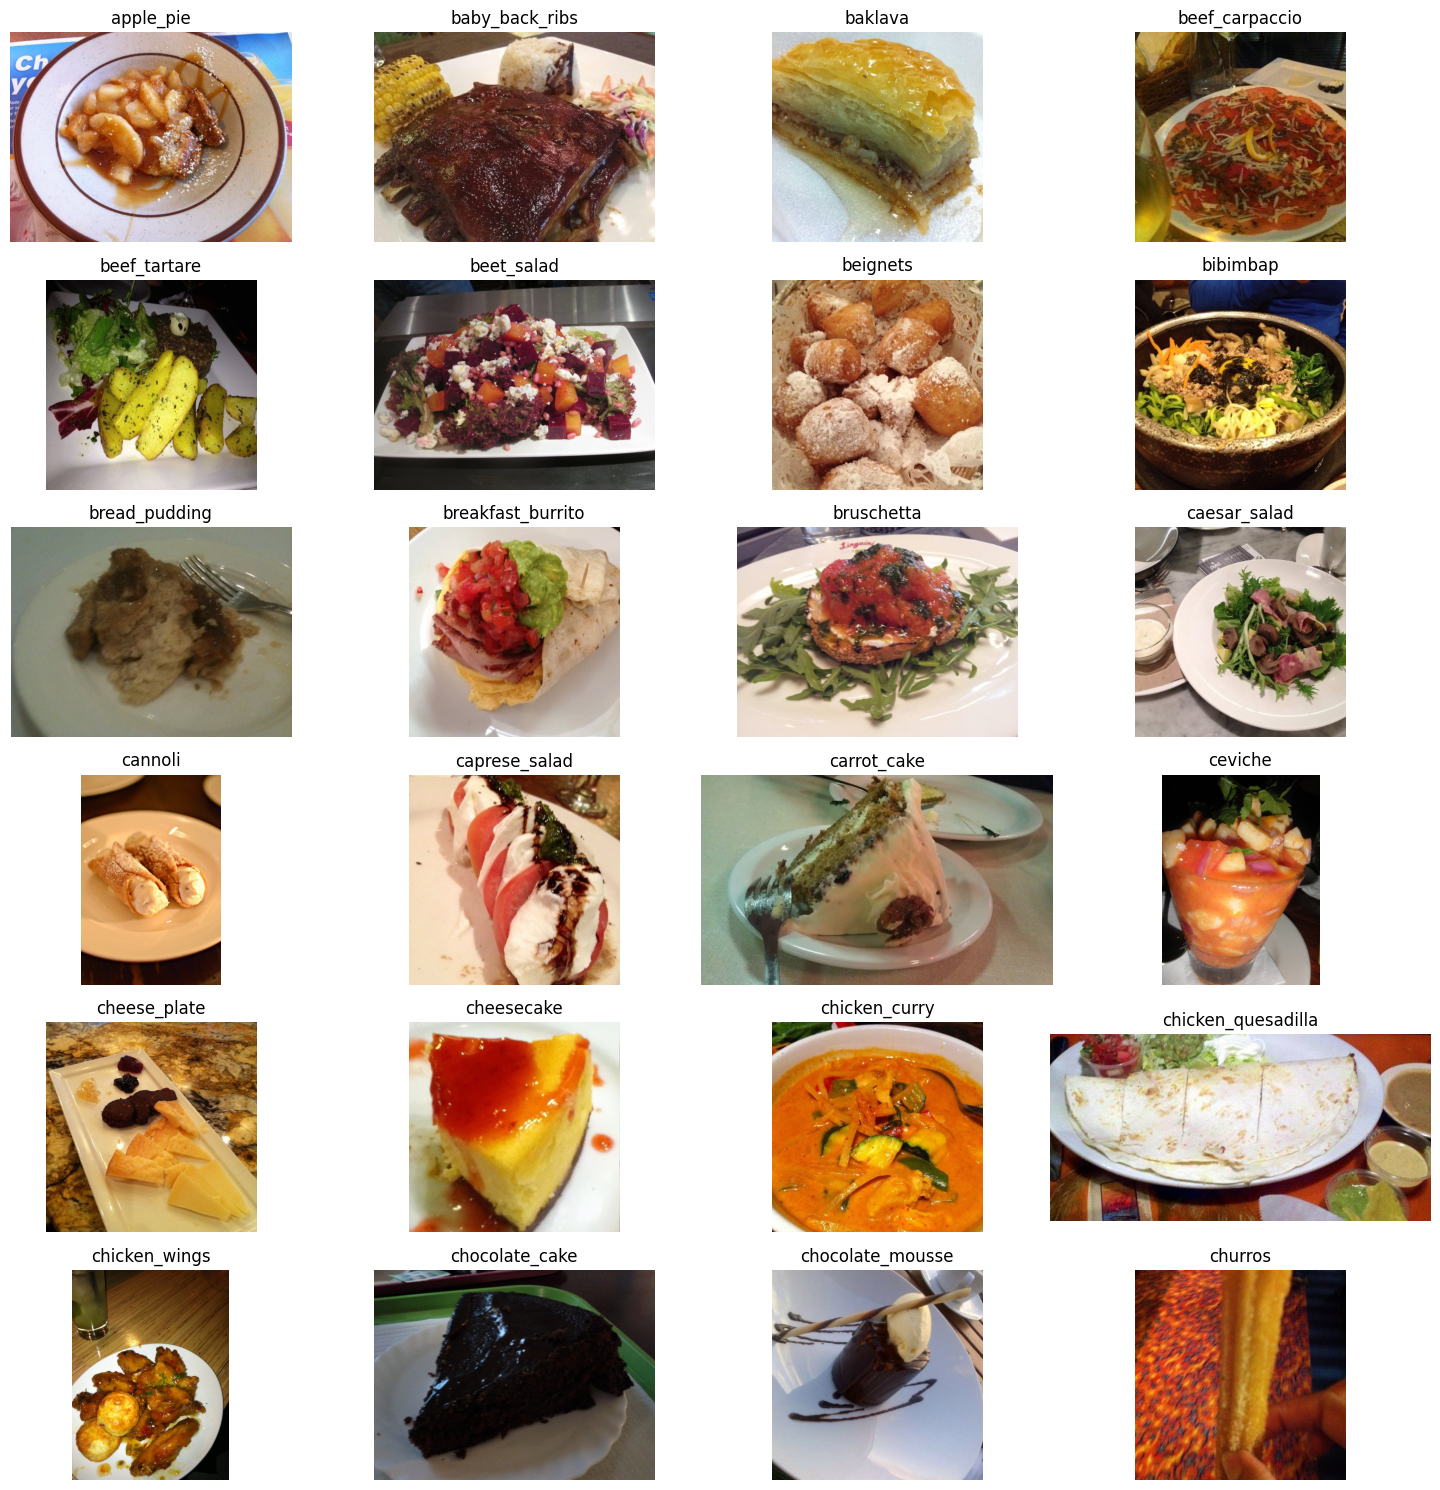

In [14]:
import matplotlib.pyplot as plt
import os

fig, axes = plt.subplots(6, 4, figsize=(15, 15))
axes = axes.flatten()

categories = sorted(os.listdir("/kaggle/input/food41/images"))

for i, category in enumerate(categories):
    
    if i >= len(axes):
        break
    category_df = df_train[df_train['labels'] == category]

    if len(category_df) > 100:
        image_path = category_df.iloc[100]['paths']
    else:
        image_path = category_df.iloc[0]['paths'] 
    img = plt.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [16]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.25
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [72]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='paths',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='paths',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='paths',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 56813 validated image filenames belonging to 101 classes.
Found 18937 validated image filenames belonging to 101 classes.
Found 25250 validated image filenames belonging to 101 classes.


In [18]:
print("Train generator:", train_images)
print("Validation generator:", val_images)
print("Test generator:", test_images)

Train generator: <keras.src.legacy.preprocessing.image.DataFrameIterator object at 0x7b5e18f40640>
Validation generator: <keras.src.legacy.preprocessing.image.DataFrameIterator object at 0x7b5e19acfb20>
Test generator: <keras.src.legacy.preprocessing.image.DataFrameIterator object at 0x7b5e19f9d570>


In [19]:
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
pretrained_model.trainable = True

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [33]:
new_model = keras.Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(len(df_train['labels'].unique()), activation='softmax'),
])

In [34]:
new_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
new_model.summary()

# Callbacks
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
chkp = keras.callbacks.ModelCheckpoint('mobilenet_v3_large_checkpoint.keras', monitor='val_accuracy', verbose=1, save_best_only=True)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobilenetV3large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 2,971,952 (11.34 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [73]:
history = new_model.fit(
    train_images,
    validation_data=val_images,
    epochs=30, 
    callbacks=[reduce_lr, early_stop, chkp]
)


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8056 - loss: 1.7158
Epoch 1: val_accuracy did not improve from 0.00855
888/888 ━━━━━━━━━━━━━━━━━━━━ 273s 305ms/step - accuracy: 0.8056 - loss: 1.7158 - val_accuracy: 0.0077 - val_loss: 11.0625 - learning_rate: 1.0000e-06
Epoch 2/30
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7966 - loss: 1.7480
Epoch 2: val_accuracy did not improve from 0.00855
888/888 ━━━━━━━━━━━━━━━━━━━━ 276s 309ms/step - accuracy: 0.7966 - loss: 1.7480 - val_accuracy: 0.0077 - val_loss: 11.0732 - learning_rate: 1.0000e-06
Epoch 3/30
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.7983 - loss: 1.7409
Epoch 3: val_accuracy did not improve from 0.00855
888/888 ━━━━━━━━━━━━━━━━━━━━ 272s 304ms/step - accuracy: 0.7983 - loss: 1.7408 - val_accuracy: 0.0077 - val_loss: 11.0953 - learning_rate: 1.0000e-06
Epoch 4/30
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8033 - loss: 1.7227
Epoch 4: val_accuracy did not improve from 0.00855
888/8

In [74]:
results = new_model.evaluate(test_images)

395/395 ━━━━━━━━━━━━━━━━━━━━ 105s 265ms/step - accuracy: 0.3386 - loss: 7.2914


In [75]:
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 61.79%


In [70]:
for layer in new_model.layers[-20:]:
    layer.trainable = True

In [76]:
calories= pd.read_csv("/kaggle/input/calories-labels/labels.csv")

In [77]:
calories.head()

,Food,Calories,Measurement
0,apple_pie,237,"per slice (1/8 of 9"" pie)"
1,baby_back_ribs,400,per 100 grams
2,baklava,335,per piece (1 piece)
3,beef_carpaccio,150,per 100 grams
4,beef_tartare,160,per 100 grams


In [78]:
def save_food_info_to_csv(predictions, class_indices, calories_df, output_file):
    class_labels = {v: k for k, v in class_indices.items()}
    
    results = []
    for prediction in predictions:
        predicted_index = prediction.argmax()
        food_item = class_labels[predicted_index]
        food_info = calories_df[calories_df['Food'] == food_item].iloc[0]
        results.append({
            'Food Item': food_info['Food'],
            'Calories': food_info['Calories'],
            'Measurement': food_info['Measurement']
        })
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)

In [79]:
predictions = new_model.predict(test_images)

395/395 ━━━━━━━━━━━━━━━━━━━━ 91s 229ms/step


In [80]:
save_food_info_to_csv(predictions, train_images.class_indices, calories, 'food_info_predictions.csv')

# Different model

In [53]:
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
pretrained_model.trainable = True

In [55]:
model = keras.Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(len(calories['Food']), activation='softmax'),
])

In [56]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [57]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=15,
)

Epoch 1/15
641/888 ━━━━━━━━━━━━━━━━━━━━ 1:08 277ms/step - accuracy: 0.0127 - loss: 6.0995

W0000 00:00:1716194646.576444     283 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


888/888 ━━━━━━━━━━━━━━━━━━━━ 364s 347ms/step - accuracy: 0.0129 - loss: 6.0309 - val_accuracy: 4.7526e-04 - val_loss: 6.0558
Epoch 2/15


W0000 00:00:1716194777.119888     281 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


888/888 ━━━━━━━━━━━━━━━━━━━━ 286s 320ms/step - accuracy: 0.0208 - loss: 5.5410 - val_accuracy: 0.0000e+00 - val_loss: 6.2561
Epoch 3/15
888/888 ━━━━━━━━━━━━━━━━━━━━ 285s 319ms/step - accuracy: 0.0383 - loss: 5.3604 - val_accuracy: 0.0000e+00 - val_loss: 6.6652
Epoch 4/15
888/888 ━━━━━━━━━━━━━━━━━━━━ 285s 319ms/step - accuracy: 0.0821 - loss: 5.0766 - val_accuracy: 5.2807e-05 - val_loss: 7.1976
Epoch 5/15
888/888 ━━━━━━━━━━━━━━━━━━━━ 278s 311ms/step - accuracy: 0.1404 - loss: 4.7370 - val_accuracy: 5.2807e-05 - val_loss: 7.7704
Epoch 6/15
888/888 ━━━━━━━━━━━━━━━━━━━━ 278s 311ms/step - accuracy: 0.2041 - loss: 4.3860 - val_accuracy: 1.0561e-04 - val_loss: 8.3706
Epoch 7/15
888/888 ━━━━━━━━━━━━━━━━━━━━ 274s 307ms/step - accuracy: 0.2597 - loss: 4.0959 - val_accuracy: 3.6965e-04 - val_loss: 8.9867
Epoch 8/15
888/888 ━━━━━━━━━━━━━━━━━━━━ 272s 304ms/step - accuracy: 0.2972 - loss: 3.8651 - val_accuracy: 7.9210e-04 - val_loss: 9.5474
Epoch 9/15
888/888 ━━━━━━━━━━━━━━━━━━━━ 264s 296ms/step - a

In [61]:
for layer in pretrained_model.layers[-5:]:
    layer.trainable = True

In [63]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[reduce_lr, early_stop, chkp]
)

Epoch 1/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5835 - loss: 2.5017
Epoch 1: val_accuracy did not improve from 0.00855
888/888 ━━━━━━━━━━━━━━━━━━━━ 270s 302ms/step - accuracy: 0.5835 - loss: 2.5017 - val_accuracy: 0.0067 - val_loss: 13.7518 - learning_rate: 1.0000e-05
Epoch 2/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.5999 - loss: 2.4205
Epoch 2: val_accuracy did not improve from 0.00855
888/888 ━━━━━━━━━━━━━━━━━━━━ 275s 308ms/step - accuracy: 0.6000 - loss: 2.4205 - val_accuracy: 0.0070 - val_loss: 14.2407 - learning_rate: 1.0000e-05
Epoch 3/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6184 - loss: 2.3470
Epoch 3: val_accuracy did not improve from 0.00855
888/888 ━━━━━━━━━━━━━━━━━━━━ 267s 299ms/step - accuracy: 0.6184 - loss: 2.3470 - val_accuracy: 0.0073 - val_loss: 14.4072 - learning_rate: 1.0000e-05
Epoch 4/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6340 - loss: 2.2853
Epoch 4: val_accuracy did not improve from 0.

In [65]:
test_loss, test_acc = model.evaluate(test_images)

395/395 ━━━━━━━━━━━━━━━━━━━━ 88s 223ms/step - accuracy: 0.3084 - loss: 8.9360


In [67]:
print(f"Loaded model test accuracy: {test_acc * 100:.2f}%")

Loaded model test accuracy: 55.72%


# Comparing both models 

Both models have been tested and it is found that the older model has a better accuracy of 61%.
